In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from  zipfile import ZipFile
import os

zip_file_path =  "/content/drive/MyDrive/project_liver/liver_dataset.zip"

target_folder = "/content/dataset/"

os.makedirs(target_folder, exist_ok=True)

with ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(target_folder)


In [ ]:
!pip install split-folders

In [ ]:
import random
import splitfolders
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import pickle

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

from tensorflow.keras import layers, models

Found GPU at: /device:GPU:0


In [ ]:
seed_value = 63
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

session = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(session)

In [ ]:
input_folder = "/content/dataset/"
splitfolders.ratio(input_folder, output=input_folder+"splitted", seed=42, ratio=(.8,.1,.1), group_prefix=None)

Copying files: 3039 files [00:00, 4503.01 files/s]


In [ ]:

project_path = input_folder + "splitted"
train_path = project_path + "/train/"
val_path = project_path + "/val/"
test_path = project_path + "/test/"


hyper_dimension = 64
hyper_batch_size = 100
hyper_epochs = 100
hyper_channels = 3
hyper_mode = 'rgb'


train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   )
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)



train= train_datagen.flow_from_directory(directory = train_path,
                                                    target_size = (hyper_dimension, hyper_dimension),
                                                    batch_size = hyper_batch_size,
                                                    color_mode = hyper_mode,
                                                    class_mode = 'binary',
                                                    seed = 42)
val = val_datagen.flow_from_directory(directory = val_path,
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size,
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)
test= test_datagen.flow_from_directory(directory = test_path,
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size,
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                               seed = 42)


test.reset()

Found 2431 images belonging to 2 classes.
Found 303 images belonging to 2 classes.
Found 305 images belonging to 2 classes.


In [ ]:
#ovaj kod nije nuznost, samo vam daje uvid u nacin prebrojavanja instanci po klasi
count_fibrosis = len([filename for filename in train.filenames if "fibrosis" in filename])
print("Fibrosis images count in training set: " + str(count_fibrosis))

count_steatosis = len([filename for filename in train.filenames if "steatosis" in filename])
print("Steatosis images count in training set: " + str(count_steatosis))

train_list_ds = tf.data.Dataset.from_tensor_slices(train.filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val.filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))


initial_bias = np.log([count_fibrosis/count_steatosis])
print(initial_bias)



cnn = keras.Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train,
                              steps_per_epoch = len(train),
                              epochs = 10,
                              validation_data = val,
                              validation_steps = len(val),
                              verbose=2)


cnn.save('/content/drive/MyDrive/model_test_1.h5')
cnn.save('/content/drive/MyDrive/model_test_1_tf',save_format='tf')

with open('/content/drive/MyDrive/trainHistoryDict01', 'wb') as file_pi:
        pickle.dump(cnn_model.history, file_pi)

Fibrosis images count in training set: 1228
Steatosis images count in training set: 1203
Training images count: 2431
Validating images count: 303
[0.02056839]
Epoch 1/10
25/25 - 12s - loss: 0.5547 - auc_18: 0.8329 - val_loss: 0.4495 - val_auc_18: 0.9314 - 12s/epoch - 487ms/step
Epoch 2/10
25/25 - 10s - loss: 0.3258 - auc_18: 0.9355 - val_loss: 0.2123 - val_auc_18: 0.9856 - 10s/epoch - 410ms/step
Epoch 3/10
25/25 - 9s - loss: 0.2217 - auc_18: 0.9738 - val_loss: 0.3913 - val_auc_18: 0.9923 - 9s/epoch - 342ms/step
Epoch 4/10
25/25 - 10s - loss: 0.1812 - auc_18: 0.9814 - val_loss: 0.2373 - val_auc_18: 0.9958 - 10s/epoch - 392ms/step
Epoch 5/10
25/25 - 10s - loss: 0.1188 - auc_18: 0.9920 - val_loss: 0.2589 - val_auc_18: 0.9990 - 10s/epoch - 413ms/step
Epoch 6/10
25/25 - 10s - loss: 0.1251 - auc_18: 0.9902 - val_loss: 0.4365 - val_auc_18: 0.9891 - 10s/epoch - 393ms/step
Epoch 7/10
25/25 - 9s - loss: 0.1001 - auc_18: 0.9938 - val_loss: 0.1571 - val_auc_18: 0.9994 - 9s/epoch - 362ms/step
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


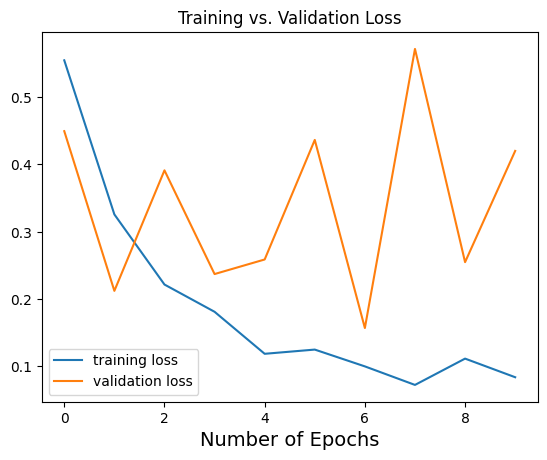

In [ ]:

import matplotlib.pyplot as plt


handler = open('/content/drive/MyDrive/trainHistoryDict01','rb')
history = pickle.load(handler)


train_loss = history['loss']
val_loss = history['val_loss']

train_auc_name = list(history.keys())[3]
val_auc_name = list(history.keys())[1]
train_auc = history[train_auc_name]
val_auc = history[val_auc_name]

plt.title("Training vs. Validation Loss")
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel("Number of Epochs", size=14)
plt.legend()

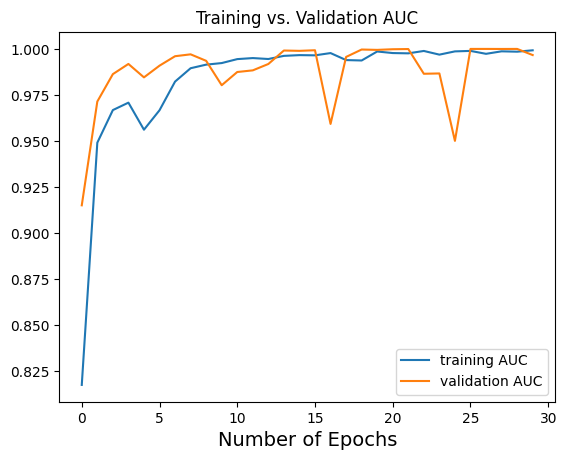

In [ ]:


val_auc_name = list(history.keys())[3]
train_auc_name = list(history.keys())[1]
train_auc = history[train_auc_name]
val_auc = history[val_auc_name]

plt.title("Training vs. Validation AUC")
plt.plot(train_auc, label='training AUC')
plt.plot(val_auc, label='validation AUC')
plt.xlabel("Number of Epochs", size=14)
plt.legend()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model('/content/drive/MyDrive/model_test.h5')

img_path = '/content/fibroza1.jpg'
img = image.load_img(img_path, target_size=(64, 64), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0
predictions = model.predict(img_array)


1/1 [==============================] - 1s 732ms/step


In [ ]:

if predictions[0, 0] > 0.81:
    print("Fibrosis")
else:
    print("Steatosis")

Fibrosis


In [ ]:

cnn = tf.keras.models.load_model('/content/drive/MyDrive/model_test_1.h5')
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 32)          0

In [ ]:
test.reset()

y_true = test.classes
Y_pred = cnn.predict_generator(test, steps = len(test))
y_pred = (Y_pred > 0.5).T[0]
y_pred_prob = Y_pred.T[0]

<ipython-input-33-38b248e06383>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test, steps = len(test))


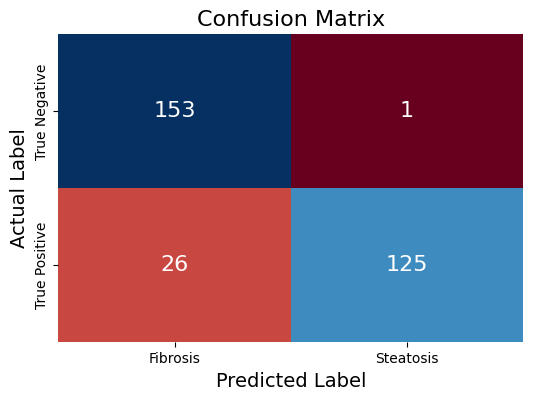

In [ ]:
# Konfuziona matrica
import seaborn as sns
import pandas as pd

cm = confusion_matrix(y_true,y_pred)

conf_df = pd.DataFrame(cm, index=["True Negative", "True Positive"], columns=["Fibrosis", "Steatosis"])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='RdBu', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Label', size=14)
plt.ylabel('Actual Label', size=14)
plt.title('Confusion Matrix', size=16)
plt.show()

In [ ]:
# Generisanje konfuzione matrice
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[153   1]
 [ 26 125]]


In [ ]:
#metrike modela
report = classification_report(y_true,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       154
           1       0.99      0.83      0.90       151

    accuracy                           0.91       305
   macro avg       0.92      0.91      0.91       305
weighted avg       0.92      0.91      0.91       305



In [ ]:
TN, FP, FN, TP = cm.ravel()
accuracy = (TP + TN) / np.sum(cm)
precision = TP / (TP+FP)
recall =  TP / (TP+FN)
specificity = TN / (TN+FP)
f1 = 2*precision*recall / (precision + recall)
stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
print(stats_summary)

[Summary Statistics]
Accuracy = 91.15% | Precision = 99.21% | Recall = 82.78% | Specificity = 99.35% | F1 Score = 90.25%
